In [2]:
from collections import defaultdict, deque
import networkx as nx
from networkx.algorithms.community import modularity
from networkx.utils import py_random_state
from itertools import combinations
from networkx import NetworkXError
from networkx.algorithms.community.community_utils import is_partition
from networkx.utils import not_implemented_for
from networkx.utils.decorators import argmap
from collections import Counter, defaultdict
from networkx.utils import groups, not_implemented_for, py_random_state
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import glob
import itertools
import time
import networkx.algorithms.community as nx_commimport 
from statistics import mean

from networkx.algorithms.community import modularity
from networkx.algorithms.community import label_propagation_communities,asyn_lpa_communities

import random

In [4]:
def initialize_community_attribute_Counter(communitiesList):
    protectedAttributeCountDict = {}
    communityCount = 0
    for i in range(len(communitiesList)):
        protectedAttributeCountDict["Community_{}".format(communityCount)] = {
            0: 0, 1: 0, 2: 0}
        communityCount += 1
    return protectedAttributeCountDict


def count_protected_attributes_frequency(G, communitiesList, protectedAttributeCountDict, attribute):
    communityCount = 0
    for community in communitiesList:

        protectedAttributeCountDict["Community_{}".format(
                        communityCount)][2] = len(community)

        for node in community:
            try:
                
                if G.nodes()[node][attribute] == 0:
                    protectedAttributeCountDict["Community_{}".format(
                        communityCount)][0] += 1
                else:
                    protectedAttributeCountDict["Community_{}".format(
                        communityCount)][1] += 1
            except KeyError:
                continue
        communityCount += 1
    return protectedAttributeCountDict


def calculate_community_balance(protectedAttributeCountDict):
    for x in protectedAttributeCountDict:
        red = protectedAttributeCountDict[x][0]
        blue = protectedAttributeCountDict[x][1]
        if red == 0 and blue == 0:
            pass
        elif red >= blue:
            balance = blue/red
            protectedAttributeCountDict[x]["balance"] = balance
        else:
            balance = red/blue
            protectedAttributeCountDict[x]["balance"] = balance

    #print("dfff",protectedAttributeCountDict)
    return protectedAttributeCountDict


def calculate_Fairness(G, communitiesList, attribute):

    protectedAttributeCountDict = initialize_community_attribute_Counter(
        communitiesList)

    protectedAttributeCountDict = count_protected_attributes_frequency(
        G, communitiesList, protectedAttributeCountDict, attribute)

    protectedAttributeCountDict = calculate_community_balance(
        protectedAttributeCountDict)

    return protectedAttributeCountDict

def average_fairness_local(partition, G):


    p = calculate_Fairness(G,partition,"protected")
    
            
    if (len(p)!=1 ):
        df = pd.DataFrame(p)
        df = df.T

    else:
        df = pd.DataFrame(p["Community_0"], index =["Communtity_0"])

    #print("df is,",df)
    zeroCounts = df[0].sum()
    oneCounts = df[1].sum()
    com_balance = df["balance"]
    nodesINcom = df[2]
 
    if zeroCounts > oneCounts:
        balance = oneCounts/zeroCounts
    else:
        balance = zeroCounts/oneCounts
    # balance = min(zeroCounts/oneCounts, oneCounts/zeroCounts)
    averageFairnes = (com_balance*nodesINcom).sum() / nodesINcom.sum()




    # print("Average Fairness for {} is {}".format(path, averageFairnes))
    # print("Global Fairness for {} is {}".format(path, balance))


    return averageFairnes, balance

In [5]:
def findbalance(red,blue):
    balance = None
   
    if (red==0 or blue==0):
        balance= 0
            
    elif(red>blue):
        balance = (blue/red)
            
    else:
        balance = (red/blue)
            

    return balance

In [6]:
def findRedBlueSizeBalance(partition, G ):
    red = 0
    blue = 0
    i = 0 
    
    mybalanceDict = defaultdict(list)
    # if(isinstance(nodesInCommunities, dict)):
    #print("ena")
    for nodesInCommunities in partition:
        #print("nodesincommunities", nodesInCommunities)
        for  node  in nodesInCommunities:
            # print("com is ", com )
            # print("dksfja;dfj", node)
            # print(G.nodes()[node]["protected"])
                # for node in nodes:
            if G.nodes()[node]["protected"]==0 :
                red += 1
            else :
                blue +=1
                
        balnce = findbalance(red,blue)
        mybalanceDict[i] = {}
        mybalanceDict[i]["red"] = red
        mybalanceDict[i]["blue"] =blue
        mybalanceDict[i]["size"] =len(nodesInCommunities)
        mybalanceDict[i]["balance"] =balnce

        red= 0
        blue= 0
        i +=1


    return mybalanceDict

In [7]:

def makemyBalanceDict( partition, G):
     
    myBalanceDict={}
    for i in range(0,len(partition)):      
        myBalanceDict[i]=partition[i]

    print(myBalanceDict)

In [8]:
#bres blue red size balance only for one community
def findRedBlueInCommesa(nodesInCommunity, G):
    red = 0
    blue = 0
    mybalanceDict = {}
    for  node  in nodesInCommunity:
            # print("com is ", com )
                # print("dksfja;dfj", node)
                # print(G.nodes()[node]["protected"])
                    # for node in nodes:
        if G.nodes()[node]["protected"]==0 :
            red += 1
        else :
            blue +=1
                    
    balance = findbalance(red,blue)  
    mybalanceDict["red"] = red
    mybalanceDict["blue"] =blue
    mybalanceDict["size"] =len(nodesInCommunity)
    mybalanceDict["balance"] =balance
    
    return mybalanceDict


In [9]:
#bres blue red size balance only for one community
def supert(df, nbr_com, com, G, plus):       #plus is for if i need plus in df or not plus ( 1 or -1)
    red = 0
    blue = 0
    mybalanceDict = {}
    for  node  in com:
            # print("com is ", com )
                # print("dksfja;dfj", node)
                # print(G.nodes()[node]["protected"])
                    # for node in nodes:
        if G.nodes()[node]["protected"]==0 :
            red += 1
        else :
            blue +=1

    #print("delksjflaskjdfl;askj",df.loc[nbr_com]["red"])               
    sumR= df.loc[nbr_com]["red"]+ ((plus)* red)
    sumB= df.loc[nbr_com]["blue"]+ ((plus)*blue)
    sizeAll = df.loc[nbr_com]["size"] + ((plus)*len(com))
    balance = findbalance(sumR, sumB)  

    mybalanceDict["red"] = sumR
    mybalanceDict["blue"] = sumB
    mybalanceDict["size"] = sizeAll
    mybalanceDict["balance"] = balance 


    return mybalanceDict


In [10]:
def reduce_df(df, nbr_com, com, graph, plus):
    
    com_change = {}
    #print(com)
    com_change = supert(df, nbr_com, com, graph, plus)
    df.iloc[nbr_com]=[com_change["red"],com_change["blue"],com_change["size"],com_change["balance"]] 
    return df



In [11]:
def findAverangeFairness(df):
    #print("balance * size",df["balance"]*df["size"])
    #print("to panw se sum",(df["balance"]*df["size"]).sum())
    #print("size sum ",df["size"].sum())
    averageFairness = (df["balance"]*df["size"]).sum() / df["size"].sum()
    return averageFairness

In [124]:

def louvain_communities(G, weight="weight", resolution=1, threshold=0.0000001, seed=None, c=0 ):
    
    #copy the original graph for find the average fairness in different steps
    #global graph_ori 
    graph_ori = G.__class__()
    graph_ori.add_nodes_from(G.nodes(data=True))
    graph_ori.add_weighted_edges_from(G.edges(data=weight, default=1))
    
    d = louvain_partitions(G,graph_ori , weight, resolution, threshold, seed, c=c)
    q = deque(d, maxlen=1)
    return q.pop()




def louvain_partitions(G,graph_ori , weight="weight", resolution=1, threshold=0.0000001, seed=None, c=0):

    partition = [{u} for u in G.nodes()]


    ###
    average, globalbalance = average_fairness_local(partition, graph_ori)
    #print("partiotion",partition)
    #print("average global", average, globalbalance)
    #print(globalbalance)
    #print("modu1",modularity(G, partition, resolution=resolution, weight=weight))
    mod =(( modularity(G, partition, resolution=resolution, weight=weight)*(1-c))+(c)*average)
    # graph is only no directed
    is_directed = False
    #is_directed = G.is_directed()
    if G.is_multigraph():
        graph = _convert_multigraph(G, weight, is_directed)
    else: 
        graph = G.__class__()
        graph.add_nodes_from(G.nodes(data=True))
        graph.add_weighted_edges_from(G.edges(data=weight, default=1))

    m = graph.size(weight="weight")
    partition, inner_partition, improvement = _one_level(graph,graph_ori , m, partition, resolution, is_directed, seed,c)
    
    improvement = True
    while improvement:
        # gh-5901 protect the sets in the yielded list from further manipulation here
        yield [s.copy() for s in partition]
        

        ###
        average, globalbalance = average_fairness_local(partition, graph_ori)
        #print(partition)
        #print("modu2",modularity(G, partition, resolution=resolution, weight=weight))
        new_mod = ((modularity(graph, inner_partition, resolution=resolution, weight="weight")*(1-c)) +((c)*average))
        #print("my new-mod apotelesma",new_mod - mod)
        if new_mod - mod <= threshold:
            return
        mod = new_mod
        graph = _gen_graph(graph, inner_partition)
        partition, inner_partition, improvement = _one_level(graph, graph_ori , m, partition, resolution, is_directed, seed, c )



def _one_level(G,graph_ori , m, partition, resolution=1, is_directed=False, seed=None,  c=0):
    
    node2com = {u: i for i, u in enumerate(G.nodes())}
    inner_partition = [{u} for u in G.nodes()]

    degrees = dict(G.degree(weight="weight"))
    Stot = list(degrees.values())
    nbrs = {u: {v: data["weight"] for v, data in G[u].items() if v != u} for u in G}
    random.seed(seed)
    rand_nodes = list(G.nodes)
    random.shuffle(rand_nodes)
    nb_moves = 1

    #print("partitions first", partition)
    redBlueBalanceSize = findRedBlueSizeBalance(partition, graph_ori)
    #print("redblue kpl",redBlueBalanceSize)
    df = pd.DataFrame(redBlueBalanceSize)
    df = df.transpose()
    #print(":$ to first df sto one level",df)

    improvement = False
    while nb_moves > 0:
        nb_moves = 0
        for u in rand_nodes:
            best_mod = 0
            best_com = node2com[u]
            
            weights2com = _neighbor_weights(nbrs[u], node2com)
            degree = degrees[u]
            Stot[best_com] -= degree

            #average, globalbalance = average_fairness_local(partition, graph_ori)

            remove_cost = -weights2com[best_com] / m + resolution * (Stot[best_com] * degree) / (2 * m**2)

            

            #mod_beforeChange =( (modularity(G,inner_partition, resolution=resolution, weight="weight"))*(c))+(1-c)*averageB

            com = G.nodes[u].get("nodes", {u})# oi komboi poy anikoyn mazi me ton u 


            averageB = findAverangeFairness(df)         #before

            
            df = reduce_df(df, best_com, com, graph_ori, -1)


            for nbr_com, wt in weights2com.items():
                
                
                gain = (remove_cost + wt / m - resolution * (Stot[nbr_com] * degree) / (2 * m**2))

                df = reduce_df(df, nbr_com, com, graph_ori, 1)

                averageA= findAverangeFairness(df) 
                

                gainbest = (gain)*(1-c) + ((c)* (averageA - averageB))
       
                df = reduce_df(df, nbr_com, com, graph_ori, -1)
                
                
                if gainbest > best_mod:
                    best_mod = gainbest
                    best_com = nbr_com

            Stot[best_com] += degree
            
            df = reduce_df(df, node2com[u],  com, graph_ori, 1)
            
            if best_com != node2com[u]:
                com = G.nodes[u].get("nodes", {u})

                partition[node2com[u]].difference_update(com)
                inner_partition[node2com[u]].remove(u)
                df = reduce_df(df, node2com[u], com, graph_ori, -1)
                
                partition[best_com].update(com)
                
                inner_partition[best_com].add(u)
                df = reduce_df(df, best_com, com, graph_ori, 1)
                
                improvement = True
                nb_moves += 1
                node2com[u] = best_com
                
 
    avgfair= findAverangeFairness(df) 
    partition = list(filter(len, partition))
    inner_partition = list(filter(len, inner_partition))
   
    return partition, inner_partition, improvement


def _neighbor_weights(nbrs, node2com):
    
    weights = defaultdict(float)
    for nbr, wt in nbrs.items():
        weights[node2com[nbr]] += wt
    return weights


def _gen_graph(G, partition):
    
    H = G.__class__()
    node2com = {}
    for i, part in enumerate(partition):
        nodes = set()
        balance =0
        for node in part:
            node2com[node] = i
            nodes.update(G.nodes[node].get("nodes", {node}))
            
        H.add_node(i, nodes=nodes, balance=balance)

    for node1, node2, wt in G.edges(data=True):
        wt = wt["weight"]
        com1 = node2com[node1]
        com2 = node2com[node2]
        temp = H.get_edge_data(com1, com2, {"weight": 0})["weight"]
        H.add_edge(com1, com2, weight=wt + temp)
    return H


def _convert_multigraph(G, weight, is_directed):
    
    if is_directed:
        H = nx.DiGraph()
    else:
        H = nx.Graph()
    H.add_nodes_from(G)
    for u, v, wt in G.edges(data=weight, default=1):
        if H.has_edge(u, v):
            H[u][v]["weight"] += wt
        else:
            H.add_edge(u, v, weight=wt)
    return H

Σος


In [14]:
def uniteRedBlue(G):
    mylist=[]
    for edge in G.edges():
        node1_attribute = G.nodes[edge[0]]['protected']
        node2_attribute = G.nodes[edge[1]]['protected']
        
        if node1_attribute != node2_attribute:
            print(f"Η ακμή {edge} ενώνει κόμβους με διαφορετικά χαρακτηριστικά.")
            mylist.append(edge)
    return mylist


In [15]:
path = "Datasets/"

In [16]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

c:\Users\Glykeria Toulina\AppData\Local\Programs\Python\Python39\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


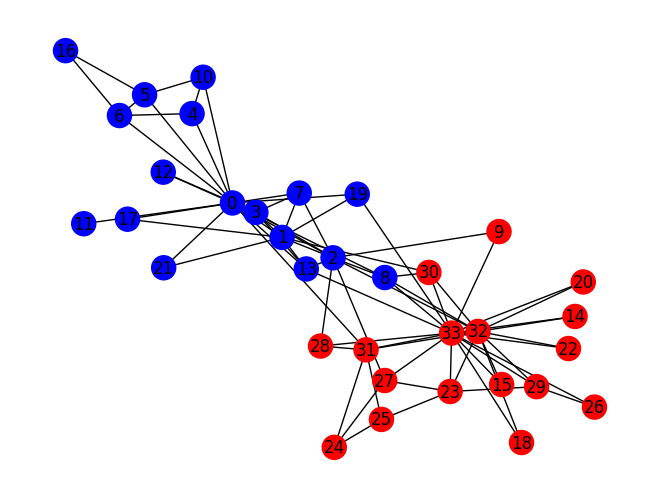

In [125]:

# Create the Karate Club graph
karate = nx.karate_club_graph()

# Assign community attribute to each node
for node in karate.nodes():
    karate.nodes[node]['protected'] = 0 if karate.nodes[node]['club']=='Mr. Hi'  else 1

# Draw the graph with nodes colored by community
pos = nx.spring_layout(karate)

colors = ['red' if karate.nodes[node]['protected'] == 1 else 'blue' for node in karate.nodes()]

#colors = [karate.nodes[node]['protected'] for node in karate.nodes()]
nx.draw(karate, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)

# Show the plot
plt.show()


In [127]:
mylist = uniteRedBlue(karate)#links between red blue nodes
mylist

Η ακμή (0, 31) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (1, 30) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (2, 9) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (2, 27) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (2, 28) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (2, 32) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (8, 30) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (8, 32) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (8, 33) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (13, 33) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.
Η ακμή (19, 33) ενώνει κόμβους με διαφορετικά χαρακτηριστικά.


[(0, 31),
 (1, 30),
 (2, 9),
 (2, 27),
 (2, 28),
 (2, 32),
 (8, 30),
 (8, 32),
 (8, 33),
 (13, 33),
 (19, 33)]

In [128]:
def multi_run_average(G,c = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3,0.2,0.1,0],title = "title"):
    df = pd.DataFrame()
    results=[]
    #c = [1,0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
    avg_len_ci={}
    dictforAll = dict()

    for ci in c :
        
        averageA = []
        modA = []
        globalbalanceA = []
        dict_results = dict()
        lencomminties=[]
        for i in range(0,3):

            
            output =(louvain_communities(G, c= ci))
            # print("output pouy blockarei ",list(output))
            communities = list(output)
            lenCom = len(communities)
            #print(communities)
            #print(lenCom)
            lencomminties.append(lenCom)
 
            average, globalbalance = average_fairness_local(communities, G)
            #print("average= ",average)
            # print(df_p)
            mod = modularity(G,communities)
            
            
            averageA.append(average)
            modA.append(mod)
            globalbalanceA.append(globalbalance)


            e = {"fairness": average ,"modularity": mod, "numberCom":lenCom, "communities": communities}

            
            dict_results[i]=e
            #print(dict_results)
        avg_len_ci[ci]=(mean(lencomminties))    
        dictforAll[ci]=dict_results
        average = mean(averageA)
        mod = mean(modA)
        globalbalance = mean(globalbalanceA)
        results.append([ci, average, mod, globalbalance,avg_len_ci[ci]])


    print(avg_len_ci)
    df.append(results, ignore_index=True)
    # [ci, average, mod, globalbalance]
    my_array = np.array(results)


    

    df_resultsEna = pd.DataFrame(my_array, columns = ['c','Average Fairness','Modularity','Global Fairness','avg_len'])


    file_name = "results/fairLouvain_results_{}.txt".format(title) 
    # Αποθήκευση του DataFrame σε ένα αρχείο κειμένου (txt)
    df_resultsEna.to_csv(file_name, index=False, sep='\t')


    return(df_resultsEna) 

In [129]:
def makeplots( title):
    file_name = "results/fairLouvain_results_{}.txt".format(title)
    df = pd.read_csv(file_name, sep='\t')



    fig, ax1 = plt.subplots()
    plt.ylim(0,1.1)

    ax2 = ax1.twinx()

    # Plot the first set of data (Average Fairness and Modularity) on the first y-axis
    plt.plot(df["c"], df["Average Fairness"], label="Average Fairness", marker='o',color='blue')

    # Plot the second set of data (Global Fairness) on the second y-axis
    plt.plot(df["c"], df["Modularity"], label="Modularity", marker='o',color='green')
    plt.ylim(0,1.1)
    # Set labels and title
    ax1.set_xlabel('c')
    ax1.set_ylabel('Average Fairness', color='b')
    
    ax2.set_ylabel('Modularity', color='g')
    plt.title(title)
   

    plt.figure(2)
    
    plt.plot(df["c"], df["avg_len"], marker='o',color='black')
    plt.xlabel('c')
    plt.ylabel('Number of Communities')
    
    plt.show()

In [130]:
#uniteRedBlue(karate)

In [131]:
multi_run_average(karate, title='karate_club')

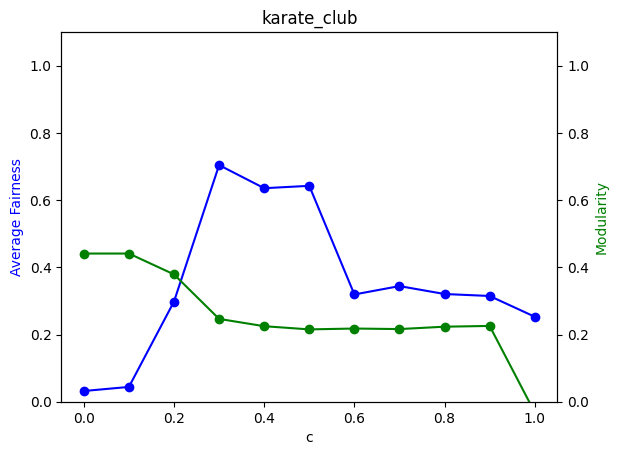

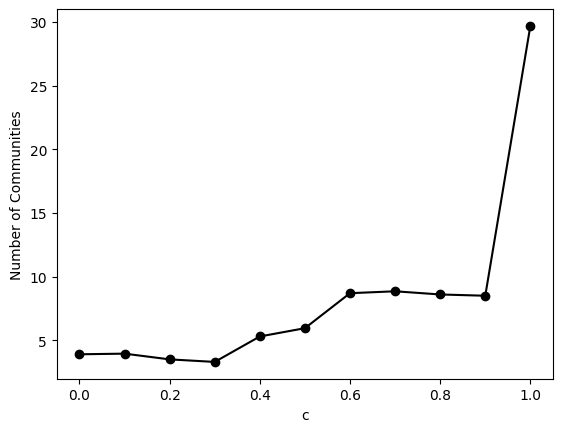

In [82]:
makeplots(title='karate_club')

Pol blogs

In [42]:
graph_blogs = nx.read_edgelist("{}/blogs/out_graph.txt".format(path),
                              nodetype=int, delimiter="\t", create_using=nx.Graph())

blog_features = pd.read_csv(
    "{}/blogs/out_community.txt".format(path), delimiter=" ", header=0 , names=[0,1])

getProtectedAttributes(graph_blogs, blog_features)

print("Number of nodes:", graph_blogs.number_of_nodes())
print("Number of edges:", graph_blogs.number_of_edges())


#σετ
blogsgraphLargestCC = max(nx.connected_components(graph_blogs), key=len)
#graph
blogsgraphLargestCC = graph_blogs.subgraph(blogsgraphLargestCC)
print("Number of nodes:", blogsgraphLargestCC.number_of_nodes())
print("Number of edges:", blogsgraphLargestCC.number_of_edges())
print("Node labels:", list(blogsgraphLargestCC.nodes()))

Number of nodes: 1222
Number of edges: 16717
Number of nodes: 1222
Number of edges: 16717
Node labels: [246, 1187, 144, 1099, 877, 727, 234, 619, 52, 332, 716, 731, 381, 392, 54, 278, 60, 1015, 841, 1040, 993, 247, 483, 873, 816, 933, 598, 1032, 977, 385, 972, 956, 57, 163, 25, 1129, 1011, 990, 1202, 1121, 812, 725, 315, 855, 123, 174, 72, 1164, 216, 508, 158, 694, 721, 51, 445, 899, 747, 38, 149, 242, 304, 1092, 998, 891, 1079, 550, 363, 1118, 1112, 808, 687, 384, 1207, 289, 481, 627, 671, 90, 919, 613, 118, 1080, 795, 215, 1160, 562, 629, 942, 553, 1098, 1146, 1097, 618, 929, 674, 548, 212, 334, 790, 454, 1012, 693, 861, 1145, 425, 23, 374, 229, 1165, 9, 732, 447, 1114, 880, 1081, 800, 661, 1221, 986, 307, 37, 487, 117, 504, 26, 313, 29, 1126, 173, 438, 804, 744, 1050, 704, 1076, 924, 340, 456, 782, 739, 1051, 211, 369, 917, 568, 560, 715, 813, 759, 995, 748, 603, 1018, 589, 848, 914, 634, 440, 1209, 681, 1013, 976, 458, 1077, 743, 943, 901, 233, 390, 70, 371, 653, 22, 502, 996, 805,

In [45]:
multi_run_average(blogsgraphLargestCC,title='political_blogs')

{1: 1068.3333333333333, 0.9: 161.66666666666666, 0.8: 125, 0.7: 128.66666666666666, 0.6: 165.33333333333334, 0.5: 106.66666666666667, 0.4: 108.33333333333333, 0.3: 36.333333333333336, 0.2: 29, 0.1: 30, 0: 11}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_13592\3669538583.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.251500,0.006045,0.921384,1068.333333
1,0.9,0.307692,0.154548,0.921384,161.666667
2,0.8,0.860897,0.084074,0.921384,125.000000
3,0.7,0.794326,0.089864,0.921384,128.666667
4,0.6,0.686627,0.098473,0.921384,165.333333
5,0.5,0.793808,0.094463,0.921384,106.666667
6,0.4,0.818636,0.117837,0.921384,108.333333
7,0.3,0.349817,0.345717,0.921384,36.333333
8,0.2,0.209177,0.398172,0.921384,29.000000
9,0.1,0.135856,0.419781,0.921384,30.000000


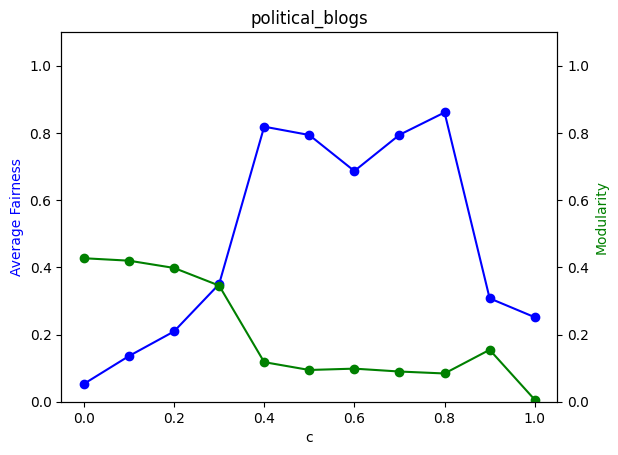

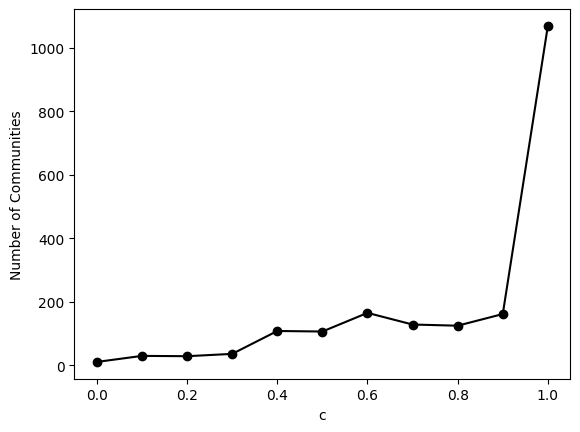

In [84]:
makeplots(title='political_blogs')

filarakia

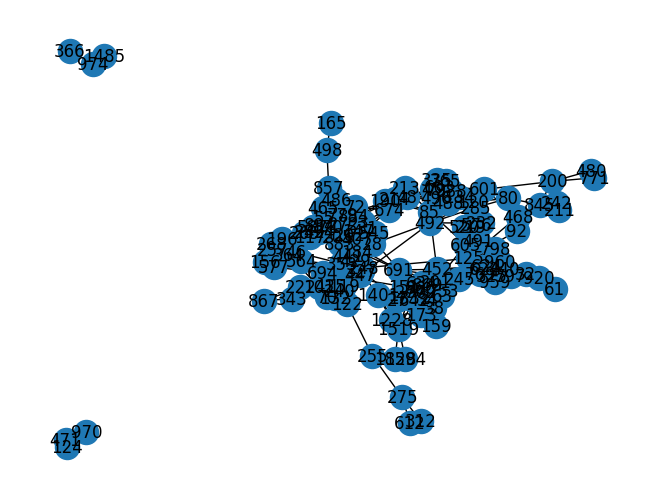

Number of nodes: 134
Number of edges: 406


In [111]:

# Step 1: Read CSV File
df = pd.read_csv(r'{}\filarakia.csv'.format(path), header=None)  # Replace with your actual CSV file name
# Step 2: Split the Cell Values
df = df[0].str.split(expand=True)
# Step 3: Extract Links
links = df.values.tolist()



# Step 4: Create a Graph
G = nx.Graph()
G.add_edges_from(links)

# Step 5: Visualize the Graph
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw the graph
nx.draw(G, pos, with_labels=True)

# Display the plot
plt.show()
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())



In [48]:
# find nodes which is connencted and belong to max componed
G1 = max(nx.connected_components(G), key=len)

# find graph which apoteleitai apo tous para panw nodes 
G2 = G.subgraph(G1)

print("Number of nodes:", G2.number_of_nodes())
print("Number of edges:", G2.number_of_edges())
print("Node labels:", list(G2.nodes()))

Number of nodes: 128
Number of edges: 401
Node labels: ['1', '55', '205', '272', '494', '779', '894', '3', '28', '147', '407', '674', '884', '27', '63', '173', '202', '327', '353', '429', '441', '492', '545', '32', '440', '624', '797', '920', '34', '151', '277', '502', '866', '45', '48', '79', '335', '496', '601', '765', '46', '117', '196', '257', '268', '170', '252', '883', '61', '125', '70', '101', '132', '240', '425', '447', '72', '857', '80', '120', '285', '468', '85', '190', '213', '214', '603', '605', '92', '845', '119', '122', '343', '364', '265', '465', '587', '488', '255', '248', '325', '491', '622', '960', '134', '388', '184', '38', '201', '452', '634', '642', '691', '694', '753', '869', '156', '159', '165', '498', '1332', '200', '480', '245', '211', '242', '219', '222', '867', '232', '798', '959', '564', '275', '312', '612', '769', '486', '531', '771', '520', '576', '577', '1401', '1228', '1519', '1594', '1828']


In [49]:
def getProtectedAttributes(G, df):
    protected_attributes = dict(zip(df[0], df[1]))
    newG = nx.set_node_attributes(G, protected_attributes, "protected")
    return newG


In [108]:
# Specify the path to your text file
file_pathlabels = r"{}\gender.txt".format(path)
#file_pathlabels
with open(file_pathlabels) as file:
    lines = file.readlines()
    #print(lines)

labels={}
# Step 2: Process Each Line
for line in lines:
    parts = line.strip().split()  # This will split the line into a list of strings and/or numbers
    #print(parts)
    #for i in range(len(parts)):
    if(parts[2]=="F"):
        labels[(parts[0])]=0
    else:
        labels[(parts[0])]=1

print(labels)
df_labels = pd.DataFrame(list(labels.items()), columns=[0, 1])
#print(df_labels)
getProtectedAttributes(G2,df_labels)
G2.nodes(data=True)

{'650': 0, '498': 0, '627': 0, '857': 0, '487': 0, '28': 1, '927': 0, '72': 0, '400': 0, '945': 0, '637': 0, '443': 0, '177': 0, '984': 0, '954': 0, '859': 1, '489': 0, '991': 1, '62': 0, '428': 1, '145': 0, '471': 0, '65': 1, '809': 0, '681': 0, '970': 0, '854': 0, '486': 0, '531': 0, '725': 1, '527': 1, '465': 0, '674': 0, '677': 1, '475': 1, '124': 0, '111': 0, '478': 0, '226': 0, '160': 0, '372': 1, '464': 0, '763': 0, '886': 0, '544': 1, '63': 0, '720': 0, '3': 1, '407': 1, '171': 1, '46': 0, '165': 0, '441': 0, '257': 0, '239': 0, '27': 1, '173': 0, '477': 1, '312': 0, '612': 0, '339': 0, '884': 0, '61': 0, '147': 1, '327': 1, '353': 1, '504': 0, '429': 1, '268': 0, '184': 1, '295': 0, '1': 1, '265': 0, '39': 0, '494': 1, '106': 0, '272': 0, '55': 0, '779': 0, '170': 0, '447': 0, '119': 0, '425': 0, '545': 0, '202': 0, '255': 0, '275': 0, '653': 1, '252': 0, '199': 0, '626': 0, '649': 0, '364': 0, '70': 0, '894': 0, '587': 0, '346': 0, '374': 0, '871': 1, '939': 1, '101': 0, '196

NodeDataView({'1': {'protected': 1}, '55': {'protected': 0}, '205': {'protected': 1}, '272': {'protected': 0}, '494': {'protected': 1}, '779': {'protected': 0}, '894': {'protected': 0}, '3': {'protected': 1}, '28': {'protected': 1}, '147': {'protected': 1}, '407': {'protected': 1}, '674': {'protected': 0}, '884': {'protected': 0}, '27': {'protected': 1}, '63': {'protected': 0}, '173': {'protected': 0}, '202': {'protected': 0}, '327': {'protected': 1}, '353': {'protected': 1}, '429': {'protected': 1}, '441': {'protected': 0}, '492': {'protected': 1}, '545': {'protected': 0}, '32': {'protected': 1}, '440': {'protected': 0}, '624': {'protected': 1}, '797': {'protected': 0}, '920': {'protected': 0}, '34': {'protected': 1}, '151': {'protected': 1}, '277': {'protected': 0}, '502': {'protected': 0}, '866': {'protected': 1}, '45': {'protected': 0}, '48': {'protected': 1}, '79': {'protected': 0}, '335': {'protected': 1}, '496': {'protected': 1}, '601': {'protected': 0}, '765': {'protected': 0},

In [51]:
multi_run_average(G2,title='friendships')

{1: 88.66666666666667, 0.9: 19, 0.8: 19.333333333333332, 0.7: 17.666666666666668, 0.6: 14.333333333333334, 0.5: 11, 0.4: 10.666666666666666, 0.3: 8, 0.2: 7, 0.1: 7.333333333333333, 0: 8}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_13592\3669538583.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.614583,0.081499,0.684211,88.666667
1,0.9,0.645833,0.448616,0.684211,19.000000
2,0.8,0.630208,0.427839,0.684211,19.333333
3,0.7,0.660700,0.504272,0.684211,17.666667
4,0.6,0.749037,0.572249,0.684211,14.333333
5,0.5,0.730632,0.591271,0.684211,11.000000
6,0.4,0.735658,0.608770,0.684211,10.666667
7,0.3,0.786706,0.625756,0.684211,8.000000
8,0.2,0.738561,0.676085,0.684211,7.000000
9,0.1,0.660485,0.697405,0.684211,7.333333


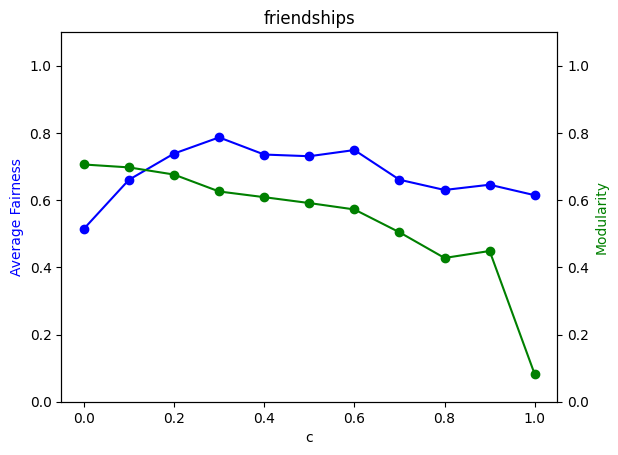

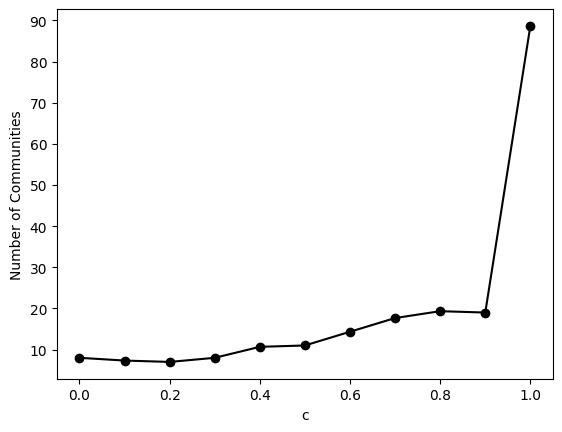

In [85]:
makeplots(title='friendships')

fb friendships

Number of nodes: 156
Number of edges: 1437
Node labels: ['1', '883', '132', '339', '653', '545', '171', '117', '196', '587', '372', '147', '55', '859', '106', '504', '471', '425', '170', '939', '272', '3', '119', '494', '205', '265', '779', '364', '240', '477', '101', '884', '441', '9', '1594', '488', '190', '325', '14', '232', '520', '65', '605', '621', '20', '387', '615', '151', '977', '1232', '513', '634', '156', '691', '34', '1870', '869', '452', '866', '1332', '502', '454', '201', '245', '687', '582', '642', '564', '1401', '753', '38', '159', '577', '857', '124', '725', '274', '871', '111', '202', '62', '428', '544', '122', '275', '63', '991', '448', '145', '343', '923', '346', '70', '649', '429', '763', '80', '941', '85', '214', '213', '650', '440', '447', '184', '1218', '181', '777', '525', '1214', '1828', '487', '280', '1339', '149', '1212', '970', '116', '836', '826', '194', '601', '954', '353', '179', '125', '1423', '1336', '466', '797', '959', '624', '769', '376', '638', '12

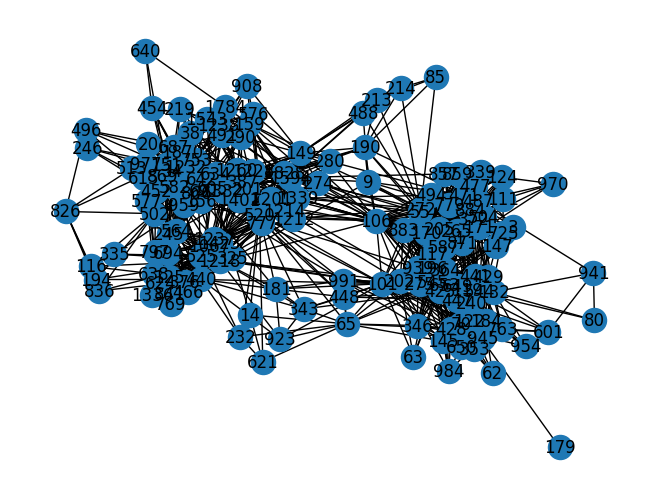

In [112]:


df_fbship = pd.read_csv(r'{}/facefilarakia.csv'.format(path), header=None) 
# Step 2: Split the Cell Values
df_fbship = df_fbship[0].str.split(expand=True)
df_fbship
df = df_fbship.rename(columns={0: 'node1', 1: 'node2', 2: 'protected'})
df =df[df['protected']=="1"] 
df=df[ ['node1','node2']]



links = df.values.tolist()

G_fbriendship = nx.Graph()
#print(df)
G_fbriendship.add_edges_from(links)

# Step 5: Visualize the Graph
pos = nx.spring_layout(G_fbriendship)  # Positions for all nodes


# find nodes which is connencted and belong to max componed
G1_fbriendship = max(nx.connected_components(G_fbriendship), key=len)

# find graph which apoteleitai apo tous para panw nodes 
G2_fbriendship = G_fbriendship.subgraph(G1_fbriendship)

print("Number of nodes:", G2_fbriendship.number_of_nodes())
print("Number of edges:", G2_fbriendship.number_of_edges())
print("Node labels:", list(G2_fbriendship.nodes()))

# Draw the graph
nx.draw(G2_fbriendship, pos, with_labels=True)

# Display the plot
plt.show()

In [113]:
# Specify the path to your text file
file_pathlabels = r"{}/gender.txt".format(path)
#file_pathlabels
with open(file_pathlabels) as file:
    lines = file.readlines()
    

labels={}
# Step 2: Process Each Line
for line in lines:
    parts = line.strip().split()  # This will split the line into a list of strings and/or numbers
    #for i in range(len(parts)):
    if(parts[2]=="F"):
        labels[(parts[0])]=0
    else:
        labels[(parts[0])]=1

#print(labels)
dfb_labels = pd.DataFrame(list(labels.items()), columns=[0, 1])
#print(dfb_labels)

getProtectedAttributes(G2_fbriendship,dfb_labels)
#G2_fbriendship.nodes(data=True)

In [56]:


multi_run_average(G2_fbriendship,title='fb_friendships')

{1: 106, 0.9: 10, 0.8: 10, 0.7: 10.333333333333334, 0.6: 8.666666666666666, 0.5: 6.666666666666667, 0.4: 6, 0.3: 7, 0.2: 5, 0.1: 5.666666666666667, 0: 5.666666666666667}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_13592\3669538583.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.641026,0.021394,0.813953,106.000000
1,0.9,0.726496,0.280671,0.813953,10.000000
2,0.8,0.694801,0.284112,0.813953,10.000000
3,0.7,0.705128,0.285777,0.813953,10.333333
4,0.6,0.715209,0.323497,0.813953,8.666667
5,0.5,0.774269,0.349673,0.813953,6.666667
6,0.4,0.861333,0.334247,0.813953,6.000000
7,0.3,0.816154,0.407811,0.813953,7.000000
8,0.2,0.772318,0.461660,0.813953,5.000000
9,0.1,0.587522,0.517718,0.813953,5.666667


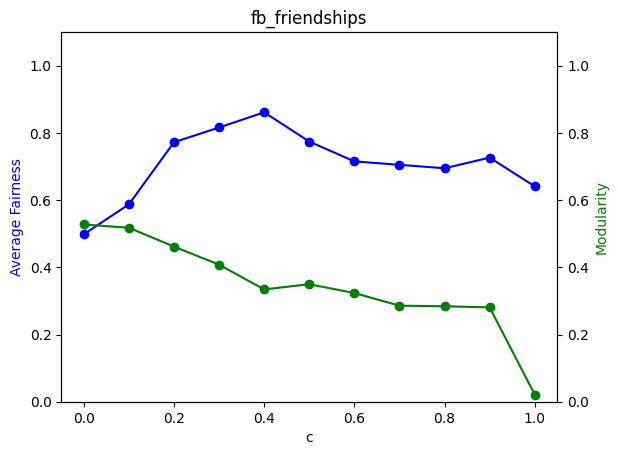

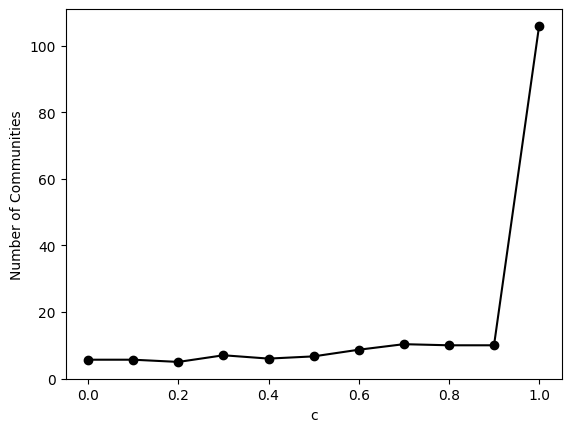

In [86]:
makeplots(title='fb_friendships')

In [91]:
#len(uniteRedBlue(G2_fbriendship))#links between two attributes

# synthetic datasets

In [69]:
#labels is list or dict work for both of them 
def formyGraph(G,labels,c=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]):
    dictsen={}
    for i in range(0,len(labels)):
        dictsen[i] = int(labels[i])
    df = pd.DataFrame(list(dictsen.items()), columns=[0, 1])
    #print(df)
    getProtectedAttributes(G, df)
    G.nodes(data=True)
    


def generate_distinct_color_hex():
    # Generate a random hue
    hue = random.random()

    # Ensure a minimum level of saturation and brightness for visibility
    saturation = random.uniform(0.5, 1.0)
    brightness = random.uniform(0.7, 1.0)

    # Convert HSV to RGB
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, brightness)

    # Scale to 255 and convert to integers
    r, g, b = int(r * 255), int(g * 255), int(b * 255)

    # Convert to hexadecimal format
    hex_color = '#{:02x}{:02x}{:02x}'.format(r, g, b)

    return hex_color

gen_graph1

Αριθμός κόμβων: 120
Αριθμός ακμών: 329
['#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#89f16a', '#89f16a', '#89f16a', '#89f16a', '#89f16a', '#89f16a', '#89f16a', '#89f16a', '#89f16a', '#89f16a', '#16c713', '#16c713', '#16c713', '#16c713', '#16c713', '#16c713', '#16c713', '#16c713', '#16c713', '#16c713', '#74e35a', '#74e35a', '#74e35a', '#74e35a', '#74e35a', '#74e35a', '#74e35a', '#74e35a', '#74e35a', '#74e35a', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#15dd6e', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#12b377', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4ecd1d', '#4

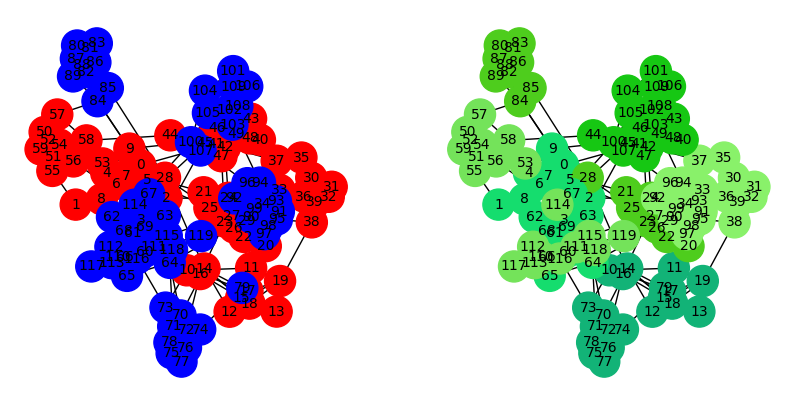

In [118]:
import colorsys

# Specify the path to your text file
file_path = r"{}\data1.txt".format(path)

# Load the data from the text file into a NumPy array
data = np.loadtxt(file_path)

# Print the loaded array
#print(data)


# Specify the path to your text file
file_pathlabels = r"{}\labels.txt".format(path)

# Load the data from the text file into a NumPy array
labels = np.loadtxt(file_pathlabels)

# Print the loaded array
#print(labels)

# Specify the path to your text file
file_pathlabels = r"{}\sensitive.txt".format(path)

# Load the data from the text file into a NumPy array
sensitive = np.loadtxt(file_pathlabels)

# Print the loaded array
#print(sensitive)

# Δημιουργία γράφου από τον πίνακα γειτνίασης
Gen_graph1 = nx.from_numpy_matrix(data)

# Εκτύπωση του αριθμού των κόμβων και ακμών
print("Αριθμός κόμβων:", Gen_graph1.number_of_nodes())
print("Αριθμός ακμών:", Gen_graph1.number_of_edges())

plt.figure(figsize=(10, 5))

# Δημιουργία λίστας με χρώματα ανά ομάδα
labels = {i: int(labels[i]-1) for i in range(len(labels))}
colors = ['r' if labels[node] == 0 else 'b' for node in Gen_graph1.nodes()]

plt.subplot(1, 2, 1)
pos = nx.spring_layout(Gen_graph1)  # Define the layout (spring layout in this case)
nx.draw(Gen_graph1, pos, with_labels=True ,node_size=500, node_color=colors, font_size=10)


sensitive = {i: int(sensitive[i])-1 for i in range(len(sensitive))}




# Generate six visually distinct random colors in hex format
colorsr = [generate_distinct_color_hex() for _ in range(12)]


colors1 = [colorsr[sensitive[node]] for node in Gen_graph1.nodes()]
print(colors1)




#colors1 = ['y' if sensitive[node] == 0 else 'g' if sensitive[node] == 1 else '#00b4d9'  if sensitive[node] == 2 else '#9E2AC6' for node in G.nodes()]

plt.subplot(1, 2, 2)
nx.draw(Gen_graph1, pos, with_labels=True ,node_size=500, node_color=colors1, font_size=10)



plt.show()


In [74]:
formyGraph(Gen_graph1,labels)
multi_run_average(Gen_graph1,title="Gen_graph1")

{1: 102.66666666666667, 0.9: 16.666666666666668, 0.8: 18.666666666666668, 0.7: 18.333333333333332, 0.6: 11.333333333333334, 0.5: 6, 0.4: 6, 0.3: 6.666666666666667, 0.2: 6.333333333333333, 0.1: 6.333333333333333, 0: 10.666666666666666}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_13592\3669538583.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.288889,0.040428,1.0,102.666667
1,0.9,0.316667,0.461578,1.0,16.666667
2,0.8,0.338889,0.450416,1.0,18.666667
3,0.7,0.300000,0.471870,1.0,18.333333
4,0.6,0.643652,0.523865,1.0,11.333333
5,0.5,0.869942,0.596555,1.0,6.000000
6,0.4,0.867542,0.581008,1.0,6.000000
7,0.3,0.837104,0.641340,1.0,6.666667
8,0.2,0.895048,0.711131,1.0,6.333333
9,0.1,0.884467,0.714215,1.0,6.333333


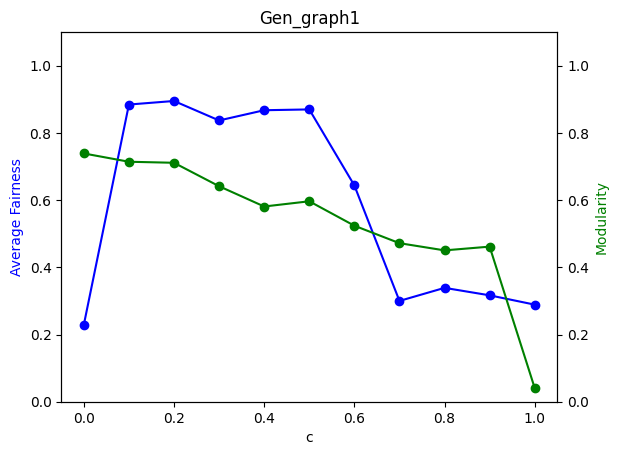

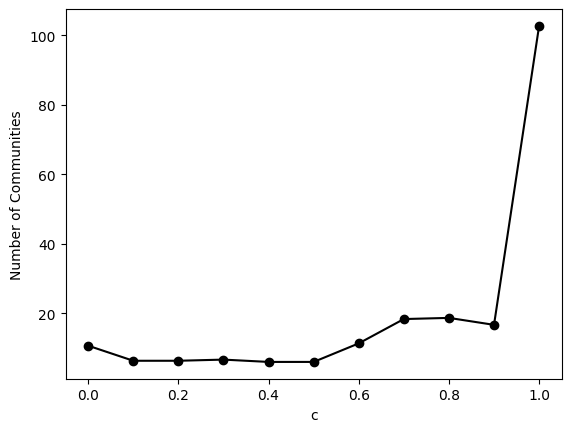

In [87]:
makeplots(title='Gen_graph1')

fixed 3

Αριθμός κόμβων: 600
Αριθμός ακμών: 14971
['#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '#f579ba', '

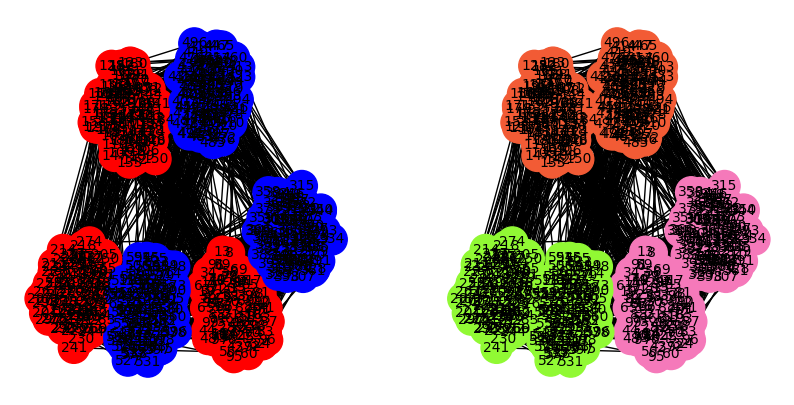

In [119]:



# Specify the path to your text file
file_path3 = r"{}\data3.txt".format(path)

# Load the data from the text file into a NumPy array
data3 = np.loadtxt(file_path3)

# Print the loaded array
#print(data)


# Specify the path to your text file
file_pathlabels3 = r"{}\labels3.txt".format(path)

# Load the data from the text file into a NumPy array
labels3 = np.loadtxt(file_pathlabels3)

# Print the loaded array
#print(labels)

# Specify the path to your text file
file_pathlabels3 = r"{}\sensitive3.txt".format(path)

# Load the data from the text file into a NumPy array
sensitive3 = np.loadtxt(file_pathlabels3)

# Print the loaded array
#print(sensitive)

# Δημιουργία γράφου από τον πίνακα γειτνίασης
Gen_graph3 = nx.from_numpy_matrix(data3)

# Εκτύπωση του αριθμού των κόμβων και ακμών
print("Αριθμός κόμβων:", Gen_graph3.number_of_nodes())
print("Αριθμός ακμών:", Gen_graph3.number_of_edges())

plt.figure(figsize=(10, 5))

# Δημιουργία λίστας με χρώματα ανά ομάδα
labels3 = {i: int(labels3[i]-1) for i in range(len(labels3))}
colors = ['r' if labels3[node] == 0 else 'b' for node in Gen_graph3.nodes()]

plt.subplot(1, 2, 1)
pos = nx.spring_layout(Gen_graph3)  # Define the layout (spring layout in this case)
nx.draw(Gen_graph3, pos, with_labels=True ,node_size=500, node_color=colors, font_size=10)


sensitive3 = {i: int(sensitive3[i])-1 for i in range(len(sensitive3))}




# Generate six visually distinct random colors in hex format
colorsr = [generate_distinct_color_hex() for _ in range(20)]


colors3 = [colorsr[sensitive3[node]] for node in Gen_graph3.nodes()]
print(colors3)




#colors1 = ['y' if sensitive[node] == 0 else 'g' if sensitive[node] == 1 else '#00b4d9'  if sensitive[node] == 2 else '#9E2AC6' for node in G.nodes()]

plt.subplot(1, 2, 2)
nx.draw(Gen_graph3, pos, with_labels=True ,node_size=500, node_color=colors3, font_size=10)



plt.show()




In [76]:
formyGraph(Gen_graph3,labels3)
multi_run_average(Gen_graph3,title='Gen_graph3')

{1: 366, 0.9: 8.666666666666666, 0.8: 9.333333333333334, 0.7: 8.666666666666666, 0.6: 9.333333333333334, 0.5: 3, 0.4: 3, 0.3: 3, 0.2: 3, 0.1: 3, 0: 6}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_13592\3669538583.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.780000,0.012619,1.0,366.000000
1,0.9,0.838889,0.412993,1.0,8.666667
2,0.8,0.886667,0.443078,1.0,9.333333
3,0.7,0.851111,0.417783,1.0,8.666667
4,0.6,0.847778,0.420495,1.0,9.333333
5,0.5,0.980395,0.535946,1.0,3.000000
6,0.4,0.974082,0.550588,1.0,3.000000
7,0.3,0.964071,0.521829,1.0,3.000000
8,0.2,0.946769,0.566789,1.0,3.000000
9,0.1,1.000000,0.624235,1.0,3.000000


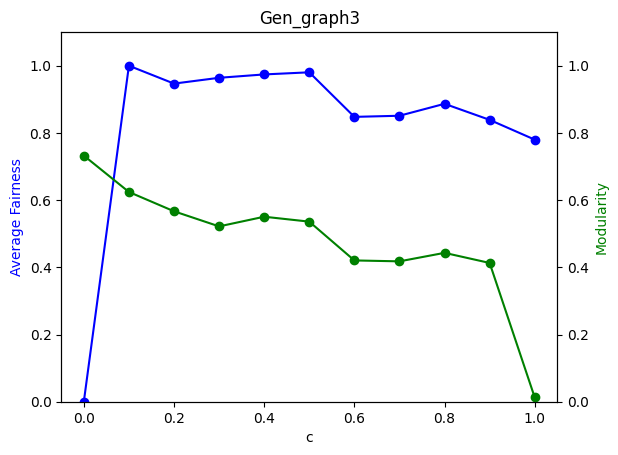

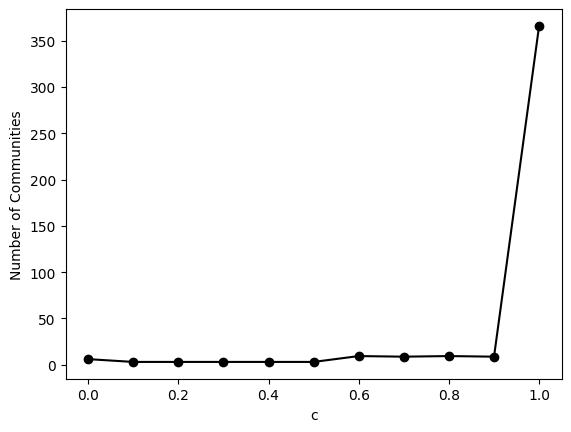

In [88]:
makeplots(title='Gen_graph3')

Gen_graph2

Αριθμός κόμβων: 200
Αριθμός ακμών: 1230
['#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1455eb', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#1db8a7', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#d75530', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#f9159f', '#

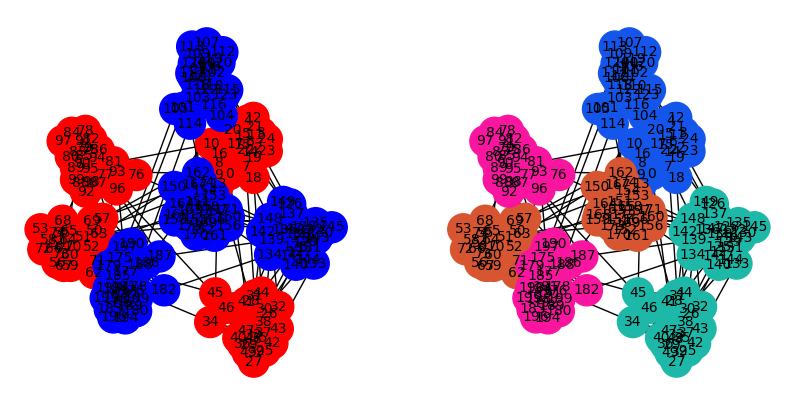

In [120]:



# Specify the path to your text file
file_path4 = r"{}\data4.txt".format(path)

# Load the data from the text file into a NumPy array
data4 = np.loadtxt(file_path4)

# Print the loaded array
#print(data)


# Specify the path to your text file
file_pathlabels4 = r"{}\labels4.txt".format(path)

# Load the data from the text file into a NumPy array
labels4 = np.loadtxt(file_pathlabels4)

# Print the loaded array
#print(labels)

# Specify the path to your text file
file_pathlabels4 = r"{}\sensitive4.txt".format(path)

# Load the data from the text file into a NumPy array
sensitive4 = np.loadtxt(file_pathlabels4)

# Print the loaded array
#print(sensitive)

# Δημιουργία γράφου από τον πίνακα γειτνίασης
Gen_graph4 = nx.from_numpy_matrix(data4)

# Εκτύπωση του αριθμού των κόμβων και ακμών
print("Αριθμός κόμβων:", Gen_graph4.number_of_nodes())
print("Αριθμός ακμών:", Gen_graph4.number_of_edges())

plt.figure(figsize=(10, 5))

# Δημιουργία λίστας με χρώματα ανά ομάδα
labels4 = {i: int(labels4[i]-1) for i in range(len(labels4))}
colors = ['r' if labels4[node] == 0 else 'b' for node in Gen_graph4.nodes()]

plt.subplot(1, 2, 1)
pos = nx.spring_layout(Gen_graph4)  # Define the layout (spring layout in this case)
nx.draw(Gen_graph4, pos, with_labels=True ,node_size=500, node_color=colors, font_size=10)


sensitive4 = {i: int(sensitive4[i])-1 for i in range(len(sensitive4))}




# Generate six visually distinct random colors in hex format
colorsr = [generate_distinct_color_hex() for _ in range(20)]


colors4 = [colorsr[sensitive4[node]] for node in Gen_graph4.nodes()]
print(colors4)




#colors1 = ['y' if sensitive[node] == 0 else 'g' if sensitive[node] == 1 else '#00b4d9'  if sensitive[node] == 2 else '#9E2AC6' for node in G.nodes()]

plt.subplot(1, 2, 2)
nx.draw(Gen_graph4, pos, with_labels=True ,node_size=500, node_color=colors4, font_size=10)



plt.show()




In [78]:
formyGraph(Gen_graph4,labels4)
multi_run_average(Gen_graph4,title='Gen_graph2')

{1: 178, 0.9: 12.666666666666666, 0.8: 13, 0.7: 12.333333333333334, 0.6: 6, 0.5: 4, 0.4: 4.333333333333333, 0.3: 4, 0.2: 4, 0.1: 6, 0: 8}


C:\Users\Glykeria Toulina\AppData\Local\Temp\ipykernel_13592\3669538583.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(results, ignore_index=True)


,c,Average Fairness,Modularity,Global Fairness,avg_len
0,1.0,0.220000,0.011453,1.0,178.000000
1,0.9,0.253333,0.519291,1.0,12.666667
2,0.8,0.243333,0.537237,1.0,13.000000
3,0.7,0.276667,0.508696,1.0,12.333333
4,0.6,0.754609,0.617943,1.0,6.000000
5,0.5,0.967561,0.682699,1.0,4.000000
6,0.4,0.913847,0.645896,1.0,4.333333
7,0.3,1.000000,0.717087,1.0,4.000000
8,0.2,1.000000,0.717087,1.0,4.000000
9,0.1,0.500000,0.776505,1.0,6.000000


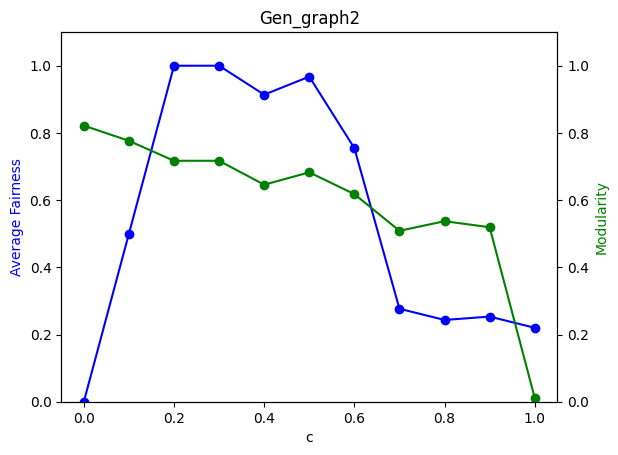

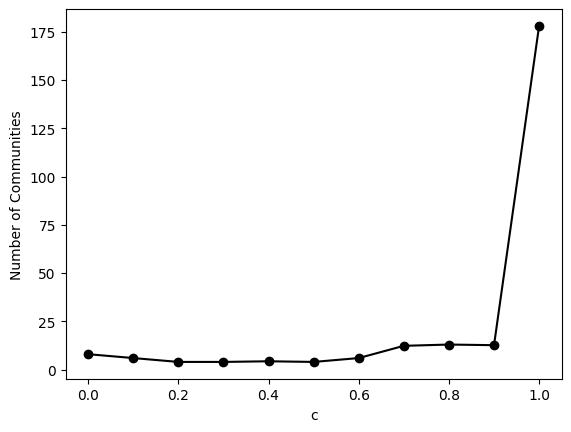

In [89]:
makeplots(title='Gen_graph2')